### Bibliotecas utilizadas

In [35]:
import sympy as sp
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

---

### Importação dos dados experimentais do motor

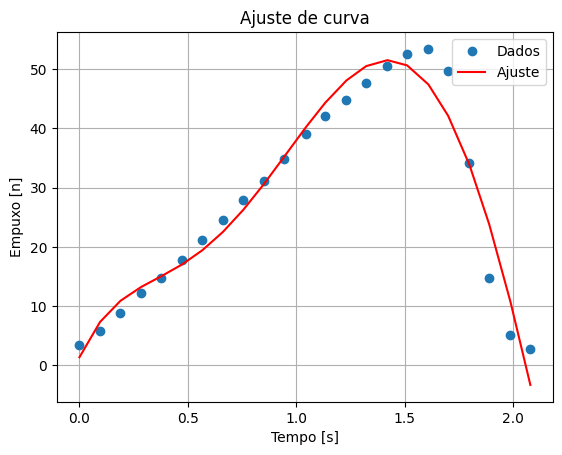

Curva ajustada: (79.70168604994986 * t) + (-205.22355146860954 * t**2) + (295.57366739446076 * t**3) + (-160.78355058940272 * t**4) + (27.40429708815195 * t**5) + 1.3475500051755298
Tempo de queima: 2.079s
Empuxo médio: 27.78N


In [36]:
data = pd.read_csv('Motor_SR1500_Sem_Óxido_dados.csv', sep=';', header=0)


def fit_curve(tempo, empuxo):
    def objective(x, a, b, c, d, e, f):
        return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

    popt, _ = curve_fit(objective, tempo, empuxo)
    return popt


def generate_curve(popt, x_values):
    a, b, c, d, e, f = popt
    return [(a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f for x in x_values]


popt = fit_curve(data['Tempo'], data['Empuxo'])
fitted_curve = generate_curve(popt, data['Tempo'])

plt.plot(data['Tempo'], data['Empuxo'], 'o', label='Dados')
plt.plot(data['Tempo'], fitted_curve, 'r-', label='Ajuste')
plt.xlabel('Tempo [s]')
plt.ylabel('Empuxo [n]')
plt.title('Ajuste de curva')
plt.legend()
plt.grid()
plt.show()

a, b, c, d, e, f = popt
curva = f'({a} * t) + ({b} * t**2) + ({c} * t**3) + ({d} * t**4) + ({e} * t**5) + {f}'

print(f'Curva ajustada: {curva}')
print(f'Tempo de queima: {data["Tempo"].iloc[-1]}s')
print(f'Empuxo médio: {data["Empuxo"].mean():.2f}N')

---

### Constantes do foguete

In [37]:
# Constantes
RO = 1.2754 # Densidade do ar (kg/m³)
G = 9.81 # Aceleração da gravidade (m/s²)

# Dados do motor
MP = 0.175 # Massa do propelente (kg)
MS = 0.483-MP # Massa seca (kg)

# Dados do foguete
CD = 0.4 # Coeficiente de arrasto
DIAM = 0.04 # Diâmetro do foguete (m)
AF = np.pi * (DIAM**2)/4 # Área de referência (m²)

# Dados do paraquedas
CDPQ = 0.9 # Coeficiente de arrasto do paraquedas
DIAMPQ = 0.6 # Diâmetro do paraquedas (m)
AFPQ = np.pi * (DIAMPQ**2)/4 # Área do paraquedas (m²) 

---

### Informações gerais

O voo do foguete pode ser dividido em 3 fases.

- Propulsada
- Balística
- Sustentada

Em cada uma das fases, diferentes forças estão em ação.

- $T$: Força de empuxo, proveniente da queima do propelente.
- $D$: Força de resistência aerodinâmica, pode ser pelo foguete ou pelo paraquedas.
- $P$: Força peso, muda de acordo com o consumo do propelente.

O interesse é definir a posição da altura no tempo $h(t)$ com foco no apogeu atingido. 
De maneira geral:

- $h(t)$ - Posição
- $\dot h(t) = V$ - Velocidade
- $\dot V = \sum F/m$ - Aceleração

Nesse estudo, o movimento é considerado em apenas em uma direção.

---

### Fase propulsada

Equação para $\dot V$:

$\dot V = [-(P(m) + D(V)) + T(t)]/m$

Onde:
- A massa m é uma função $m(t)$;
- O empuxo T é uma função $T(t)$;
- D é uma função $D(V)$

Equações envolvidas:

In [38]:
# Variáveis tempo, gravidade, massa, massa do propelente, massa seca,
t, g, m, mp, ms, p, c, a, tq = sp.symbols('t g m mp ms p c a tq')
# densidade do meio (ar), coeficiente de arrasto, área de referência, tempo de queima

h = sp.symbols(r'h', cls=sp.Function)
h = h(t)  # Altura
h_dot = sp.diff(h, t)  # dh/dt (Velocidade)
h_ddot = sp.diff(h_dot, t)  # d²h/dt² (Aceleração)

Definição da aceleração ou $\dot V$ considerando o empuxo e massa variáveis com o tempo e a resistência aerodinâmica variável com a velocidade:

In [39]:
mt = mp + ms  # Massa total
m = mt - ((mp/tq)*t)  # Função da massa
P = m * g  # Força peso

D = 0.5 * p * h_dot**2 * c * a  # Força de arrasto # Empuxo

T = sp.sympify(curva) # Empuxo

vdot = (-P - D + T)/m

dvdt = sp.Eq(vdot, h_ddot)  # Equação da aceleração
sol = sp.solve([dvdt], [h_ddot])

dvdt.simplify()

Eq(Derivative(h(t), (t, 2)), (-g*(-mp*t + tq*(mp + ms)) - tq*(0.5*a*c*p*Derivative(h(t), t)**2 - 27.40429708815195*t**5 + 160.78355058940272*t**4 - 295.57366739446076*t**3 + 205.22355146860954*t**2 - 79.70168604994986*t - 1.3475500051755298))/(-mp*t + tq*(mp + ms)))

Sistemas de equações solucionáveis:

In [40]:
ddhddt_f = sp.lambdify((h_dot, t, g, mp, ms, p, c, a, tq), sol[h_ddot]) # Função da aceleração 
dhdt_f = sp.lambdify(h_dot, h_dot) # Função da velocidade 
pesot = sp.lambdify((t, mp, ms, tq, g), P) # Função da massa total

# Sistema de equações
def dSdt(S, t, g, mprop, mseco, ro, cd, af, tq):
    h, hd = S

    return [dhdt_f(hd),
            ddhddt_f(hd, t, g, mprop, mseco, ro, cd, af, tq)]

Condições iniciais e solução da fase propulsada:

In [41]:
tq = data["Tempo"].iloc[-1] # Tempo de queima (s)
tempo_simulacao1 = tq # Tempo fase propulsada
passo = 1000  # 1e-3
t1 = np.linspace(0, tempo_simulacao1, passo+1) # Vetor de tempo 1

h0 = 0 # Altura inicial
hd0 = 0 # Velocidade inicial

solve = odeint(dSdt, y0=[h0, hd0], t=t1, args=(G, MP, MS, RO, CD, AF, tq))

Visualização gráfica da posição e velocidade do início até o fim da queima do propelente:

Altura de burnout: 109.59m
Velocidade máxima durante a queima: 131.42m/s


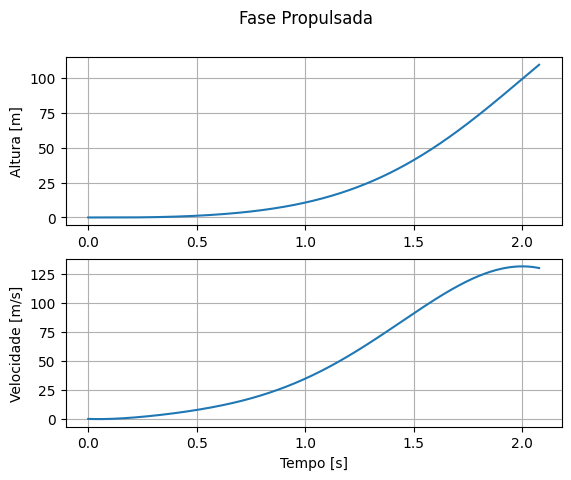

In [42]:
hpos = solve.T[0] # Altura
hdot = solve.T[1] # Velocidade

print(f'Altura de burnout: {max(hpos):.2f}m')
print(f'Velocidade máxima durante a queima: {max(hdot):.2f}m/s')

fig, axs = plt.subplots(2)

fig.suptitle('Fase Propulsada')

axs[0].plot(t1, hpos)
axs[0].set_ylabel('Altura [m]')
axs[0].grid()
axs[1].plot(t1, hdot)
axs[1].set_ylabel('Velocidade [m/s]')
axs[1].grid()

plt.xlabel('Tempo [s]')
plt.show()

---

### Fase balística

Não há mais a ação de força do motor nem a variação de massa.

$\dot V = -(P + D(V))/m$

Onde:
- A massa m é constante;
- O empuxo T não atua mais;
- D é uma função $D(V)$

A resistência aerodinâmica é relacionada ao diâmetro do foguete e contrária ao seu movimento.

Definição da aceleração ou $\dot V$:

In [43]:
m = ms # Massa seca constante
P = m * g # Força peso constante

D = 0.5 * p * h_dot**2 * c * a # Força de arrasto

vdot = -(P + D)/m

dvdt = sp.Eq(vdot, h_ddot) # Equação da aceleração
sol = sp.solve([dvdt],[h_ddot])

dvdt.simplify()

Eq(Derivative(h(t), (t, 2)), -0.5*a*c*p*Derivative(h(t), t)**2/ms - g)

Sistemas de equações solucionáveis:

In [44]:
ddhddt_f = sp.lambdify((h_dot, g, ms, p, c, a), sol[h_ddot]) # Função da aceleração 

# Sistema de equações
def dSdt(S, t, g, mseco, ro, cd, af):
    h, hd = S

    return [dhdt_f(hd),
            ddhddt_f(hd, g, mseco, ro, cd, af)]

Condições iniciais e solução da fase balística:

In [45]:
tb = 10.6 # Tempo fase balística (aproximar experimentalmente) (s)
t2 = np.linspace(t1[-1], t1[-1]+tb, passo+1) # Vetor de tempo 2

h0 = hpos[-1] # Altura inicial
hd0 = hdot[-1] # Velocidade inicial

solve2 = odeint(dSdt, y0=[h0, hd0], t=t2, args=(G, MS, RO, CD, AF))

O valor de $tb$ pode variar experimentalmente de acordo com a altura que se deseja abrir o paraquedas, para esse caso desejamos uma altura próxima de $100m$.

Visualização gráfica do percurso da fase balística, fase onde ocorre o apogeu, até a abertura do paraquedas:

Altura de apogeu: 602.88m


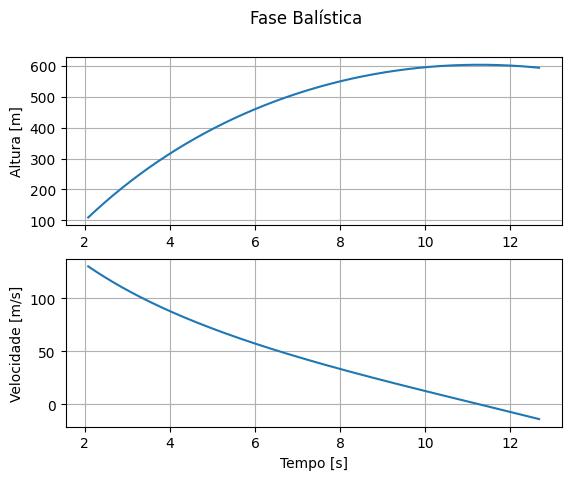

In [46]:
hpos2 = solve2.T[0] # Altura
hdot2 = solve2.T[1] # Velocidade

print(f'Altura de apogeu: {max(hpos2):.2f}m')

fig, axs = plt.subplots(2)
fig.suptitle('Fase Balística')

axs[0].plot(t2, hpos2)
axs[0].set_ylabel('Altura [m]')
axs[0].grid()
axs[1].plot(t2, hdot2)
axs[1].set_ylabel('Velocidade [m/s]')
axs[1].grid()

plt.xlabel('Tempo [s]')
plt.show()

---

### Fase sustentada

Fase em que o paraquedas é acionado para sustentar a queda do foguete sem danos ao aterrisar.

Mantem-se as variáveis anteriores, porém o Coeficiente de Arrasto e Área de Referência considerados são do paraquedas.

A resistência aerodinâmica se torna força contrária à força peso.

$\dot V = (-P + D(V))/m$

Onde:
- A massa m é constante;
- O empuxo T não atua mais;
- D é uma função $D(V)$

Obtenção da aceleração ou $\dot V$:

In [47]:
vdot = (-P + D)/m

dvdt = sp.Eq(vdot, h_ddot) # Equação da aceleração
sol = sp.solve([dvdt],[h_ddot])

dvdt.simplify()

Eq(Derivative(h(t), (t, 2)), 0.5*a*c*p*Derivative(h(t), t)**2/ms - g)

Sistemas de equações solucionáveis:

In [48]:
ddhddt_f = sp.lambdify((h_dot, g, ms, p, c, a), sol[h_ddot]) # Função da aceleração

# Sistema de equações
def dSdt(S, t, g, mseco, ro, cd, af):
    h, hd = S

    if h <= 0:
        return [0, 0]
    else:
        return [dhdt_f(hd),
                ddhddt_f(hd, g, mseco, ro, cd, af)]

Condições iniciais e solução da fase sustentada:

In [49]:
# Calculo da velocidade de queda estimada com o paraquedas e o peso do foguete
V_queda = np.sqrt((2 * MS * G) / (RO * CDPQ * AFPQ)) # Velocidade de queda (m/s)

t_queda = hpos2[-1] / V_queda # Tempo de queda (s) assumindo velocidade constante

t3 = np.linspace(t2[-1], t2[-1]+t_queda, passo+1) # Vetor de tempo 3

h0 = hpos2[-1] # Altura final da fase balística
hd0 = hdot2[-1] # Velocidade final da fase balística

solve3 = odeint(dSdt, y0=[h0, hd0], t=t3, args=(G, MS, RO, CDPQ, AFPQ))

print(f'Velocidade de queda estimada: {V_queda:.2f}m/s')

Velocidade de queda estimada: 4.32m/s


Visualização gráfica do percurso da fase sustentada:

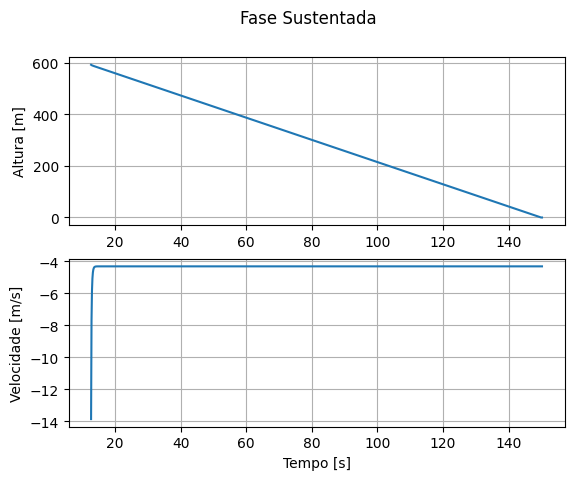

In [50]:
hpos3 = solve3.T[0] # Altura
hdot3 = solve3.T[1] # Velocidade

fig, axs = plt.subplots(2)

fig.suptitle('Fase Sustentada')

axs[0].plot(t3, hpos3)
axs[0].set_ylabel('Altura [m]')
axs[0].grid()
axs[1].plot(t3, hdot3)
axs[1].set_ylabel('Velocidade [m/s]')
axs[1].grid()

plt.xlabel('Tempo [s]')
plt.show()

---

### Juntando as fases e Resultados finais

Apogeu: 602.88m

Tempo até o apogeu: 11.28s

Abertura do paraquedas: 593.18m

Tempo total de voo: 150.15s

Velocidade de impacto: 4.32m/s

Velocide máxima: 131.42m/s


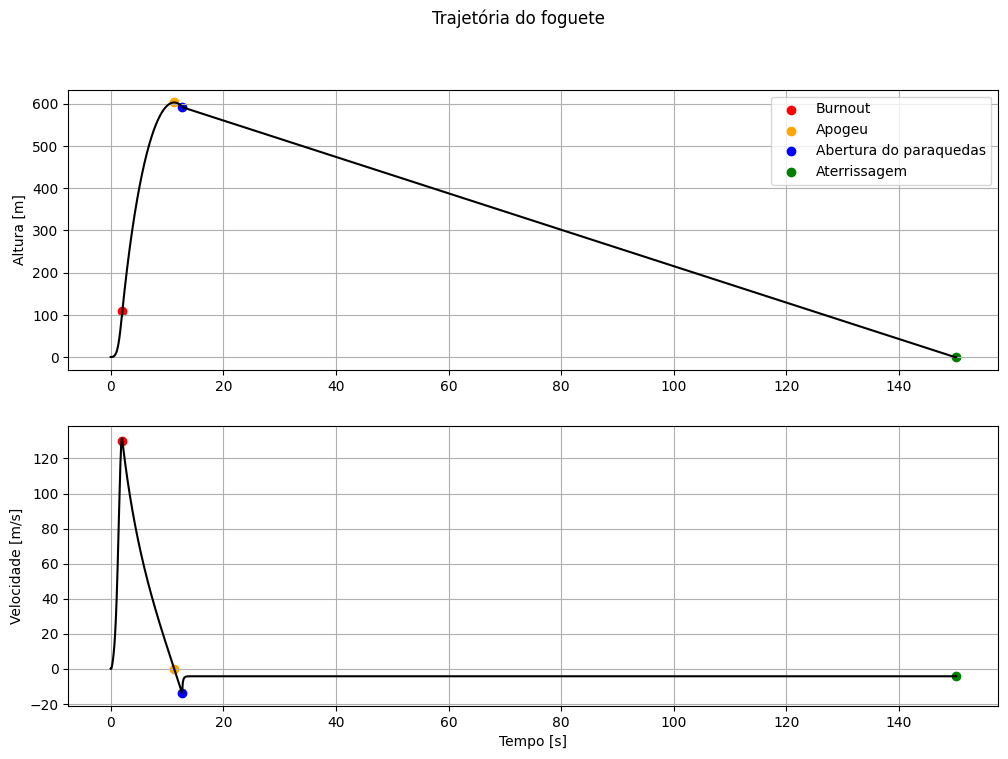

In [51]:
t_total = np.concatenate((t1, t2, t3)) # Tempo total
h_total = np.concatenate((hpos, hpos2, hpos3)) # Altura total
hd_total = np.concatenate((hdot, hdot2, hdot3)) # Velocidade total

print(f'Apogeu: {max(h_total):.2f}m\n')
print(f'Tempo até o apogeu: {t_total[np.argmax(h_total)]:.2f}s\n')
print(f'Abertura do paraquedas: {hpos2[-1]:.2f}m\n')
print(f'Tempo total de voo: {t_total[-1]:.2f}s\n')
print(f'Velocidade de impacto: {abs(hd_total[-1]):.2f}m/s\n')
print(f'Velocide máxima: {max(hd_total):.2f}m/s')

# Gráfico de altura e velocidade
fig, axs = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Trajetória do foguete')
axs[0].plot(t_total, h_total, c='k')
axs[0].scatter(t1[-1], hpos[-1], c='r', label='Burnout')
axs[0].scatter(t_total[np.argmax(h_total)], max(h_total), c='orange', label='Apogeu')
axs[0].scatter(t2[-1], hpos2[-1], c='b', label='Abertura do paraquedas')
axs[0].scatter(t_total[-1], h_total[-1], c='g', label='Aterrissagem')
axs[0].legend()
axs[0].set_ylabel('Altura [m]')
axs[0].grid()
axs[1].plot(t_total, hd_total, c='k')
axs[1].scatter(t1[-1], hdot[-1], c='r', label='Burnout')
axs[1].scatter(t_total[np.argmax(h_total)], hdot2[np.argmax(hpos2)], c='orange', label='Apogeu')
axs[1].scatter(t2[-1], hdot2[-1], c='b', label='Abertura do paraquedas')
axs[1].scatter(t_total[-1], hdot3[-1], c='g', label='Aterrissagem')
axs[1].set_ylabel('Velocidade [m/s]')
axs[1].grid()
plt.xlabel('Tempo [s]')
plt.show()